In [19]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
import plotnine as gg
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
topdir="Performance"
subdir='W47_2020'
figures = "figures"

## Directories and Filepath

In [21]:
def paths(topdir, subdir, figures):
    
    folderpath = os.path.join(Path("../", topdir), subdir)

    figpath = os.path.join(folderpath, figures)


    def create_folder(path):
             
        if not os.path.exists(path):
        
            print ("directory is created")
        
            return os.makedirs(path)
    
        else:
            
            return print ("directory is already existed")

    
    
    folder = create_folder(folderpath)

    figdir = create_folder(figpath)
    
    return folderpath, figpath


folderpath, figpath = paths(topdir, subdir, figures)
print(folderpath)
print(figpath)

directory is already existed
directory is already existed
../Performance/W47_2020
../Performance/W47_2020/figures


## Defining Paths

In [22]:
def csv_paths(folderpath):
    
    csvpath = [os.path.join(folderpath, f) for f in os.listdir(folderpath)]
    
    apriso_path = [f for f in csvpath if "Apriso" in f][0]
    
    tracker_path = [f for f in csvpath if "Tracker" in f][0]
    
    buffer_path = [f for f in csvpath if "Buffer" in f][0]
    
    return apriso_path, tracker_path, buffer_path


apriso_path, tracker_path, buffer_path = csv_paths(folderpath)

print(apriso_path)
print(tracker_path)
print(buffer_path)



../Performance/W47_2020/Apriso_NOV22.csv
../Performance/W47_2020/Tracker_NOV22.csv
../Performance/W47_2020/Repair Department Buffer Report.csv


### Creating Merged dataframe which resulted after matching Tracker and Apriso Data

In [23]:
def create_merged_csv(apriso_path, tracker_path, figpath):
    
    tracker_columns = ['DATE','RBU 6701_SN', 'FAIL Category', 'Fail Group', 
                       'TRSH NAME','STATUS', 'Notes', 'REPAIR Person',
                       'REPAIR NOTES', 'PRE-TRSH Person']

    data_tracker = (pd.read_csv(tracker_path, engine='python')
                    .loc[:, tracker_columns]
                   )
    
    
    apriso_columns = ['Serial #', 'Level 1', 'Level 2', 'Level 3', 'ProductNo']
    
    data_apriso = (pd.read_csv(apriso_path)
                   .loc[:, apriso_columns]
                  )


    data_apriso['RBU 6701_SN'] = data_apriso[data_apriso.columns[0:4]].apply(
        lambda x: ''.join(x.dropna().astype(str)),
        axis=1
    )
    
    data_apriso = (data_apriso.loc[:, ['RBU 6701_SN', 'ProductNo']])
    
    merged = data_tracker.merge(data_apriso, how='left', left_on='RBU 6701_SN', right_on= 'RBU 6701_SN')

    merged = merged.drop_duplicates()

        
    merged.loc[(merged['ProductNo'] == 'ROA1286713/1') & (merged['FAIL Category'] == 'RF'), 'FAIL Category'] = "MBFT"
    
    
    merged['RBU 6701_SN'] = merged['RBU 6701_SN'].str.replace("ea2a", "EA2A")
    
    
    merged['RBU 6701_SN'] = merged['RBU 6701_SN'].str.replace("e23", "E23")
    
    return merged

merged = create_merged_csv(apriso_path, tracker_path, figpath)

merged.head()

/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3,9) have mixed types.Specify dtype option on import or set low_memory=False.


,DATE,RBU 6701_SN,FAIL Category,Fail Group,TRSH NAME,STATUS,Notes,REPAIR Person,REPAIR NOTES,PRE-TRSH Person,ProductNo
0,"Monday, November 16, 2020",EA2A106620,DIG.,"CHK_SYNC_LED_HUE, Hue of SYNC LED (11)",Maged Y.,PASS,NaN,NaN,NaN,NaN,KRK10101/21
2,"Monday, November 16, 2020",EA2A106677,DIG.,"ID.D15000A4, ID.D15000A4",Maged Y.,PASS,NaN,NaN,NaN,NaN,KRK10101/21
4,"Monday, November 16, 2020",EA2A106701,DIG.,"RU_CPRI_P0_1, Check if Sliver CPRI port 0 is Up",Maged Y.,BB+Node,NaN,NaN,NaN,NaN,KRK10101/21
6,"Monday, November 16, 2020",EA2A106544,DIG.,"STAB_10M_5MIN, Stability for measured clock - ...",Maged Y.,PASS,NaN,Rachel E.,Passive Comp.,Kazeem K.,KRK10101/21
8,"Monday, November 16, 2020",EA2A052783,I.C.O. (TRSH),NaN,NaN,NaN,NaN,NaN,NaN,Tuan L.,NaN


# Repair department

## Functions

This function is for renaming of Failure Categories for all departments

In [29]:

def repair_dept_namechange(x):
    
    if (x['FAIL Category'] == 'RF') | (x['FAIL Category'] == 'DIG.'):
        return "Radio"
    
    elif (x['FAIL Category'] == 'MBFT'):
        return "MBFT"
    
    elif (x['FAIL Category'] == 'MVI'):
        return "MVI"
    
    elif (x['FAIL Category'] == 'SMA Repair') | (x['FAIL Category'] == 'SMA REPAIR'):
        return "SMA Repair"
    
    elif (x['FAIL Category'] == 'I.C.O. (TRSH)'):
        return "I.C.O. (TRSH)"
    
    elif (x['FAIL Category'] ==  'Re-work Order'):
        return "Re-work Order"
    
    elif (x['FAIL Category'] ==  "Mech."):
        return "Mech."
    
    elif (x['FAIL Category'] == 'Validation Radio Test'):
        return 'Validation Radio Test'
    
    
    
    
TRSH_NAME=['Bo B.','Maged Y.','Matthew T.','Mekedes W.',
           'Michael Smith U.','Omar V.','Samuel T.',
           'Sujin K.','Yohannes A.']


REPAIR_NAME=['Daniel S.','Khaliah T.','Nelson L.',
             'Rachel E.','Tamela B.','Thai L.', 'Tri N.']


PRETRSH_NAME=['Alton W.','Eric T.','Kazeem K.','Luis G.','Scott N.','Ve']


MVI_NAME=['Phat N.','Tri N.','Tuan L.']


Ist_shift = ['Bo B.','Maged Y.','Matthew T.','Michael Smith U.',
             'Sujin K.','Yohannes A.', 'Daniel S.','Khaliah T.',
             'Rachel E.', 'Alton W.','Kazeem K.','Scott N.', 
             'Phat N.','Tuan L.']


Sec_shift = ['Mekedes W.','Omar V.','Samuel T.','Nelson L.',
             'Tamela B.','Thai L.', 'Tri N.', 'Eric T.',
             'Luis G.','Ve']


    



## TRSH Performance and KPI

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/W47_2020/figures/Trouble_shooters_performance_W47_2020.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/W47_2020/figures/Trouble_shooters_KPI.png


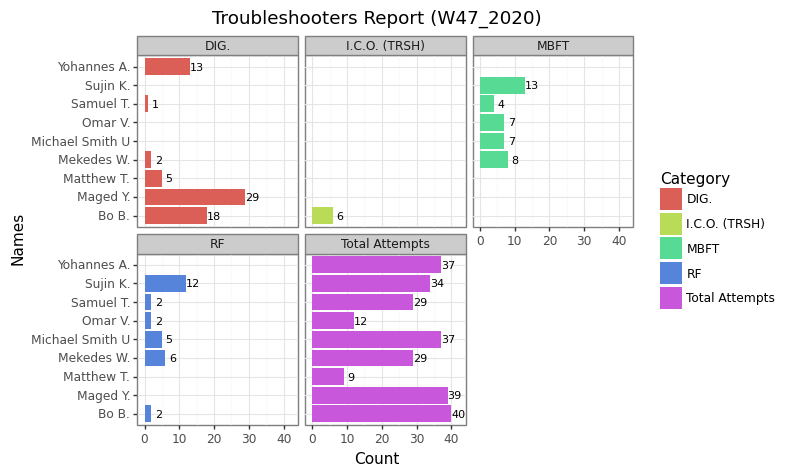

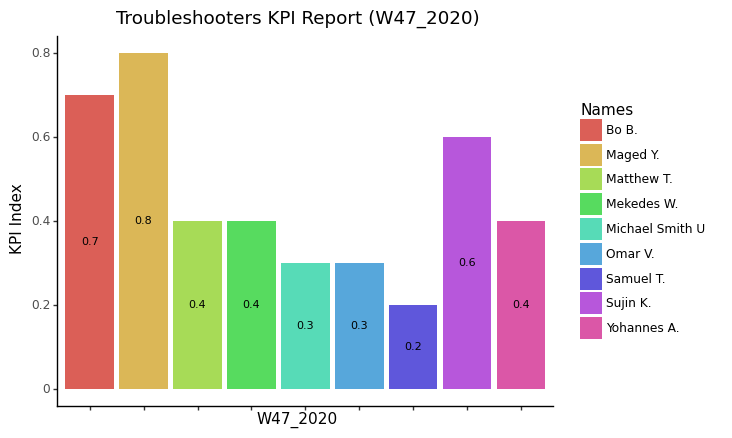

(<ggplot: (7020807929)>, <ggplot: (7015417885)>)

In [30]:
def TRSH_Performance_KPI(merged, figpath):
    
    cat_condition=["DIG.", "RF", "MBFT", "I.C.O. (TRSH)"]

    merged_df = (merged[merged['FAIL Category'].isin(cat_condition)]
                .groupby(['TRSH NAME','ProductNo', "FAIL Category"])
                .count()
                .reset_index()
                .groupby(['TRSH NAME', "FAIL Category"])
                .sum()
                .reset_index()
                .loc[:, ['TRSH NAME','FAIL Category', 'DATE']]
                .rename(columns={'TRSH NAME': 'Names',
                                 'DATE': "Count",
                                 'FAIL Category': "Category"
                                })

                )

    tmp = (merged[merged['FAIL Category'].isin(cat_condition)]
                .groupby(['TRSH NAME',"FAIL Category"])
                .count()
                .reset_index()
                .groupby(['TRSH NAME', "FAIL Category"])
                .sum()
                .reset_index()
                .loc[:, ['TRSH NAME','FAIL Category', 'DATE']]
                .rename(columns={'TRSH NAME': 'Names',
                                 'DATE': "Count",
                                 'FAIL Category': "Category"
                                })

                )

    ICO_TRSH = tmp[tmp['Category'] == "I.C.O. (TRSH)"]

    merged_df = merged_df.append(ICO_TRSH).reset_index().drop(columns='index')



    total = (merged.groupby('TRSH NAME').count()
            .reset_index()
            .loc[:, ['TRSH NAME','DATE']]
            .rename(columns={'TRSH NAME': 'Names',
                             'DATE': "Count",
                            })
            )



    total['Category'] = 'Total Attempts'

    total = total.loc[:, ['Names', 'Category', 'Count']]
    fn = merged_df.append(total)



    p = gg.ggplot(fn, gg.aes(x='Names', y='Count',fill="Category", label='Count')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_bw() + \
        gg.coord_flip() + \
        gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                 size=8, nudge_x=0, nudge_y=2, show_legend=True) + \
        gg.labs(title= 'Troubleshooters Report' + ' (' + str(subdir) + ')')



    p = p + gg.facet_wrap('~ Category', nrow=2)



    #print(p + facet_wrap('~ mask', nrow=2, scales="free_y"))




    gg.ggsave(filename='Trouble_shooters_performance_' + str(subdir) +'.png', plot = p, path = figpath)
    
    
    ## Calculating TRSH KPI
    
   
    
    #min_threshold_radio=25
    target_radio=35     ## 65 min / radio



    #min_threshold_board=25
    target_board=45       ## 50 min / board



    def repair_dept_kpi(x):

        if (x['Category'] == 'RF') | (x['Category'] == 'DIG.'):
            return "Radio"

        elif (x['Category'] == 'MBFT') | (x['Category'] == "I.C.O. (TRSH)"):
            return "Board"




    def KPI_radio(x):

        if (x['Category'] == "Radio") & (x['Names'] == 'Matthew T.'):

            k = (x['Count']) / 14

            return k

        elif (x['Category'] == "Radio") & (x['Names'] == 'Omar V.'):

            k = (x['Count']) / 24.5

            return k 

        elif (x['Category'] == "Radio"):

            k = (x['Count']) / (target_radio)

            return k 


    def KPI_board(x):

        if (x['Category'] == "Board") & (x['Names'] == 'Matthew T.'):

            k = (x['Count']) / 18

            return k 

        elif (x['Category'] == "Board") & (x['Names'] == 'Omar V.'):

            k = (x['Count'])  / 31.5

            return k 

        elif (x['Category'] == "Board"):

            k = (x['Count']) / (target_board)

            return k


        
    kpi = merged_df.copy()


    kpi['Category'] = kpi.apply(repair_dept_kpi, axis=1)


    kpi = (kpi.groupby(["Names", "Category"])
           .sum()
           .reset_index()

          )



    kpi['KPI_Radio'] = kpi.apply(KPI_radio, axis=1)



    kpi['KPI_board'] = kpi.apply(KPI_board, axis=1)





    kpi = (kpi.groupby("Names")
           .sum()
           .reset_index()
           .assign(Total_Kpi = lambda x: np.round(x['KPI_Radio'] + x['KPI_board'], 1))
          )




    g = gg.ggplot(kpi, gg.aes(x='Names', y='Total_Kpi',fill="Names", label='Total_Kpi')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.labs(title= 'Troubleshooters KPI Report'+ ' (' + str(subdir) + ')',
                x=str(subdir),
                y="KPI Index"
               ) + \
        gg.theme(axis_text_x=gg.element_blank())


    gg.ggsave(filename='Trouble_shooters_KPI.png', plot = g, path = figpath)





    return p, g

TRSH_Performance_KPI(merged, figpath)


### Pre-TRSH performance and KPI

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/W47_2020/figures/Pre_Trouble_shooters_performance_W47_2020.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/W47_2020/figures/Pre-Trouble_shooters_KPI_W47_2020.png


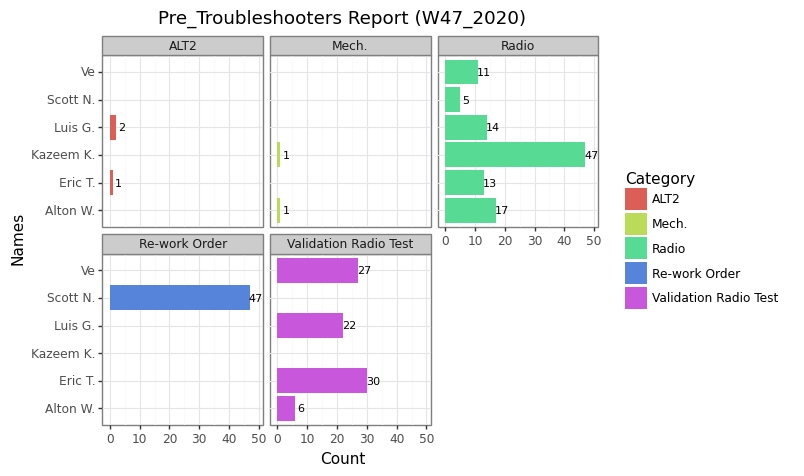

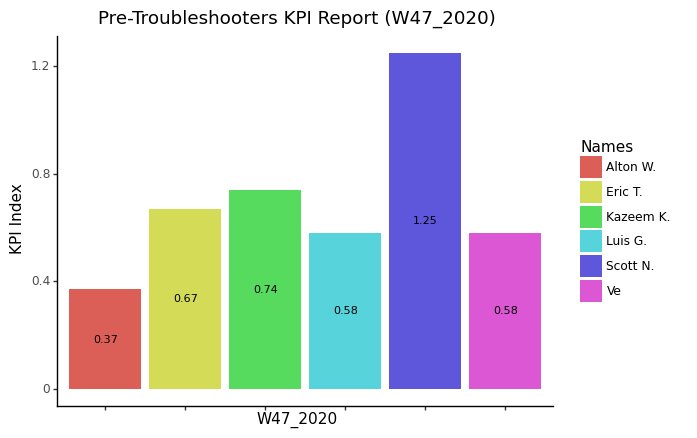

(<ggplot: (7021290965)>, <ggplot: (7015495785)>)

In [31]:
def pre_TRSH_Performance_KPI(merged, figpath, PRETRSH_NAME):
    
    
    def repair_dept_pre_TRSH(x):


        if (x['FAIL Category'] == 'RF') | (x['FAIL Category'] == 'DIG.'):
            return "Radio"

        elif (x['FAIL Category'] ==  'Re-work Order'):
            return "Re-work Order"

        elif (x['FAIL Category'] == "Mech.") & (x['STATUS'] == "ALT2"):
            return "ALT2"

        elif (x['FAIL Category'] == "Mech.") & (x['STATUS'] != "ALT2"):
            return "Mech."

        elif (x['STATUS'] == "Pre-Scrap"):
            return "ROA Scrap"

        elif (x['FAIL Category'] == 'Validation Radio Test'):
            return 'Validation Radio Test'


        
# ## Calling RF and DIG. as Radio and count twice for similar person   
    

    tmp = merged.copy()


    tmp['Category'] = tmp.apply(repair_dept_pre_TRSH, axis=1)



    pre_TRSH_categories = ['Radio', 'Validation Radio Test', 'ALT2', 'Re-work Order',
           'Mech.', 'ROA Scrap']





    tmp = (tmp[tmp['Category'].isin(pre_TRSH_categories) &  
              tmp['PRE-TRSH Person'].isin(PRETRSH_NAME)]
          )


    tmp1 = tmp.drop_duplicates(['RBU 6701_SN', 'PRE-TRSH Person', 'Category'], keep='last')



    pre_TRSH = (tmp1.groupby(['PRE-TRSH Person','Category'])
    .count()
    .reset_index()
    .loc[:, ['PRE-TRSH Person','Category', 'DATE']]
    .rename(columns={'PRE-TRSH Person': 'Names',
                    'FAIL Category':"Category",
                    'DATE': "Count"})

          )



    pre = gg.ggplot(pre_TRSH, gg.aes(x='Names', y='Count',fill="Category", label='Count')) + \
            gg.geom_col(stat="identity") + \
            gg.theme_bw() + \
            gg.coord_flip() + \
            gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                     size=8, nudge_x=0, nudge_y=2, show_legend=True) + \
            gg.labs(title= 'Pre_Troubleshooters Report' + ' (' + str(subdir) + ')')



    pre = pre + gg.facet_wrap('~ Category', nrow=2)


    gg.ggsave(filename='Pre_Trouble_shooters_performance_' + str(subdir) +'.png', plot = pre, path = figpath)






    # min_threshold_radio=55
    # min_threshold_rework=30

    y  = 65  #(Radio=Mech.=Validation_test=65 min)

    target_Radio=65   ## 35 min / radio 
    target_Mech=65    ## 35 min / Mech.
    target_ALT2=90    ## 25 min / ALT2
    target_Rework=40  ## 60 min / Rework
    target_VRT=65     ## 35 min / VRT




    def KPI_preTRSH(x):

        if (x['Category'] == "Radio") | (x['Category'] == 'Mech.') | (x['Category'] == 'Validation Radio Test') :

            k = (x['Count']) / y

            return k

        elif x['Category'] == 'ALT2':

            k = (x['Count']) / target_ALT2

            return k

        elif x['Category'] == 'Re-work Order':

            k = (x['Count']) / target_Rework

            return k




    KPI_PTRSH = pre_TRSH.copy()



    KPI_PTRSH['KPI_Pre-TRSH'] = KPI_PTRSH.apply(KPI_preTRSH, axis=1)





    KPI_PTRSH = (KPI_PTRSH.groupby("Names")
           .sum()
           .reset_index()
           .loc[:, ['Names','Count', 'KPI_Pre-TRSH']]


          )

    KPI_PTRSH['KPI_Pre-TRSH'] = np.round(KPI_PTRSH['KPI_Pre-TRSH'], 2)


    g = gg.ggplot(KPI_PTRSH, gg.aes(x='Names', y='KPI_Pre-TRSH',fill="Names", label='KPI_Pre-TRSH')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.labs(title= 'Pre-Troubleshooters KPI Report' + ' (' + str(subdir) + ')' ,
                x=str(subdir),
                y="KPI Index"
               ) + \
        gg.theme(axis_text_x=gg.element_blank())




    gg.ggsave(filename='Pre-Trouble_shooters_KPI_'+ str(subdir) + '.png', plot = g, path = figpath)
    
    


    return pre, g


pre_TRSH_Performance_KPI(merged, figpath,PRETRSH_NAME)

## MVI Performance and KPI

/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/W47_2020/figures/MVI_performance_modified_W47_2020.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/W47_2020/figures/KPI_MVI_W47_2020.png


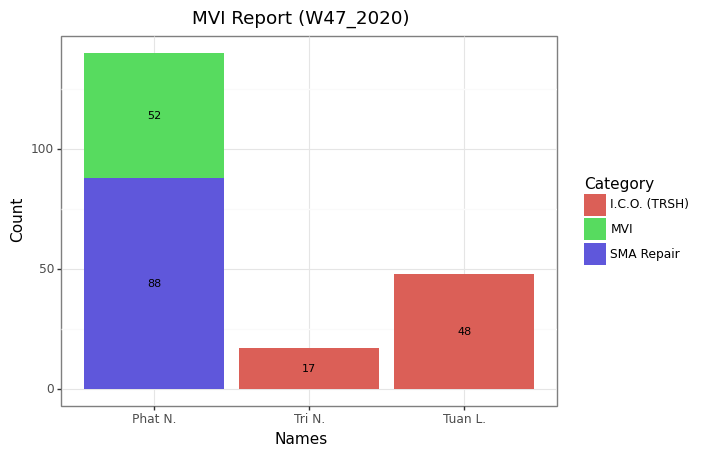

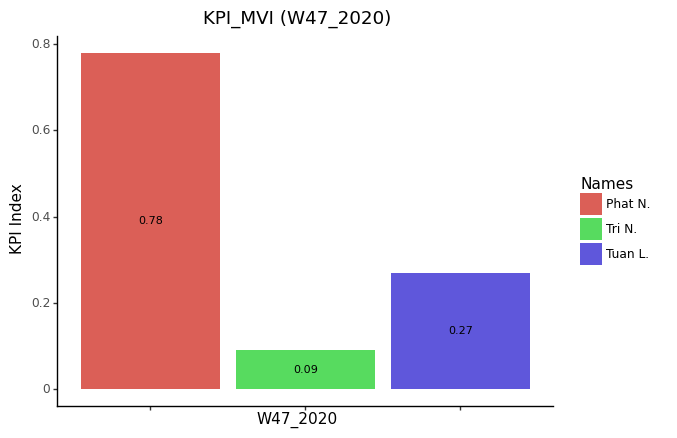

(<ggplot: (7017202261)>, <ggplot: (7014758425)>)

In [32]:
def MVI_Performance_KPI(merged, figpath, MVI_NAME):
    
    
    def repair_dept_namechange(x):

        if (x['FAIL Category'] == 'RF') | (x['FAIL Category'] == 'DIG.'):
            return "Radio"

        elif (x['FAIL Category'] == 'MBFT'):
            return "MBFT"

        elif (x['FAIL Category'] == 'MVI'):
            return "MVI"

        elif (x['FAIL Category'] == 'SMA Repair') | (x['FAIL Category'] == 'SMA REPAIR'):
            return "SMA Repair"

        elif (x['FAIL Category'] == 'I.C.O. (TRSH)'):
            return "I.C.O. (TRSH)"

        elif (x['FAIL Category'] ==  'Re-work Order'):
            return "Re-work Order"

        elif (x['FAIL Category'] ==  "Mech."):
            return "Mech."

        elif (x['FAIL Category'] == 'Validation Radio Test'):
            return 'Validation Radio Test'
    
    


    mvi = merged[merged['PRE-TRSH Person'].isin(MVI_NAME)]


    mvi['FAIL Category'] = mvi.apply(repair_dept_namechange, axis=1)





    mvi = (mvi.groupby(['PRE-TRSH Person',"FAIL Category"])
           .count()
           .reset_index()
           .loc[:, ['PRE-TRSH Person','FAIL Category', 'DATE']]
           .rename(columns={'PRE-TRSH Person': 'Names',
                                   'FAIL Category':"Category",
                                   'DATE': "Count"})

                 )


    mvi_plot = gg.ggplot(mvi, gg.aes(x='Names', y='Count', fill="Category", label='Count')) + \
        gg.geom_bar(stat="identity") + \
        gg.theme_bw() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.labs(title= 'MVI Report' + ' (' + str(subdir) + ')' ) 






    gg.ggsave(filename='MVI_performance_modified_'+ str(subdir) + '.png', plot = mvi_plot, path = figpath)
    
    
    
    
    #min_threshold_board_mvi=170
    
    target_board_mvi=180  # 12 min /board




    def mvi_kpi(x):

        if (x['Category'] == 'MVI') | (x['Category'] == 'SMA Repair') | (x['Category'] == 'I.C.O. (TRSH)'):
            return "board_mvi"



    def KPI_MVI(x):

        if (x['Category'] == "board_mvi"):

            k = (x['Count'])/ (target_board_mvi)

            return np.round(k, 2)


    
        
    KPI_mvi = mvi.copy()


    KPI_mvi['Category'] = KPI_mvi.apply(mvi_kpi, axis=1)


    KPI_mvi = (KPI_mvi.groupby(["Names", "Category"])
           .sum()
           .reset_index()

          )


    KPI_mvi['KPI_MVI'] = KPI_mvi.apply(KPI_MVI, axis=1)






    mvi_kpi = gg.ggplot(KPI_mvi, gg.aes(x='Names', y='KPI_MVI',fill="Names", label='KPI_MVI')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.labs(title= 'KPI_MVI' + ' (' + str(subdir) + ')',
                x=str(subdir),
                y="KPI Index"
               ) + \
        gg.theme(axis_text_x=gg.element_blank())



    gg.ggsave(filename='KPI_MVI_'+ str(subdir) + '.png', plot = mvi_kpi, path = figpath)
    
    return mvi_plot, mvi_kpi





MVI_Performance_KPI(merged, figpath, MVI_NAME)



## Soldering Performance and KPI

/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/W47_2020/figures/soldering_performanceW47_2020.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/W47_2020/figures/soldering_KPIW47_2020.png


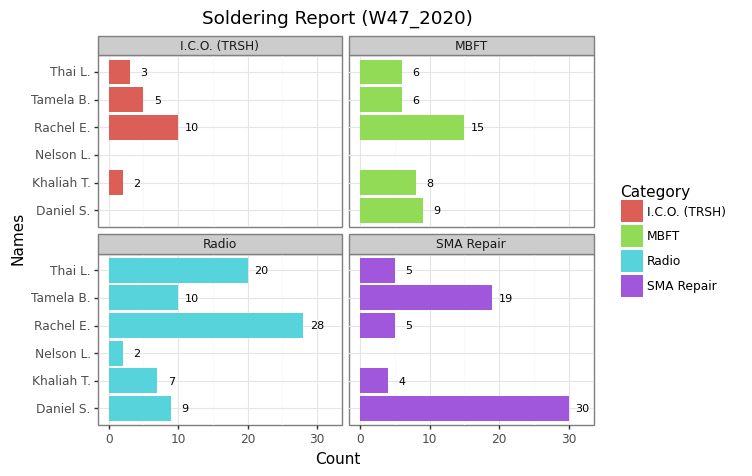

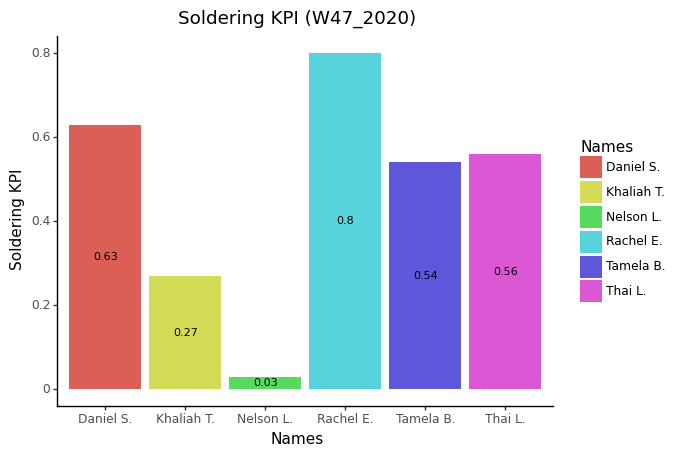

(<ggplot: (7020563409)>, <ggplot: (7020533629)>)

In [33]:
def soldering_Performance_KPI(merged, figpath, REPAIR_NAME):
    
      
    def repairsoldering_dept_namechange(x):

        if (x['FAIL Category'] == 'RF') | (x['FAIL Category'] == 'DIG.'):
            return "Radio"

        elif (x['FAIL Category'] == 'SMA Repair') | (x['FAIL Category'] == 'SMA REPAIR'):
            return "SMA Repair"

        elif (x['FAIL Category'] == 'I.C.O. (TRSH)'):
            return "I.C.O. (TRSH)"

        elif (x['FAIL Category'] ==  "MBFT"):
            return "MBFT"




    repair = merged[merged['REPAIR Person'].isin(REPAIR_NAME)]

    repair['FAIL Category'] = (repair
                               .apply(repairsoldering_dept_namechange, axis=1)
                              )


    repair = (repair
              .drop_duplicates(['RBU 6701_SN',"FAIL Category",'REPAIR Person', 'REPAIR NOTES'], keep='last')
             )




    repair = (repair.groupby(['FAIL Category','REPAIR Person'])
              .count()
              .reset_index()
              .loc[:, ['FAIL Category', 'REPAIR Person','DATE']]
              .rename(columns={'REPAIR Person': 'Names',
                                   'FAIL Category':"Category",
                                   'DATE': "Count"})
             )



    soldering_plot = gg.ggplot(repair, gg.aes(x='Names', y='Count', fill="Category", label='Count')) + \
        gg.geom_bar(stat="identity") + \
        gg.theme_bw() + \
        gg.coord_flip() + \
        gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                     size=8, nudge_x=0, nudge_y=2, show_legend=True) + \
        gg.labs(title= 'Soldering Report' + ' (' + str(subdir) + ')')



    soldering_plot = soldering_plot + gg.facet_wrap('~ Category', nrow=2)






    gg.ggsave(filename='soldering_performance' + str(subdir) + '.png', plot = soldering_plot, path = figpath)


    # ## Calculating Soldering KPI



    soldering_categories=['Passive Comp.', '1 x IC', '2 x IC', 
                          'Connector', 'Pre-Scrap','3 x IC']


    target_connector = 75     ## 30min per connector
    target_2_3IC = 32         ## 70min per 2_IC or 3_IC
    target_1IC_Passive = 90   ## 25min per 1_IC or Passive Comp.


    def kpi_soldering(x):

        if x['Category'] == 'Connector':

            k = (x['Count']) / target_connector

            return k

        elif (x['Category'] == '2 x IC') | (x['Category'] == '3 x IC'):

            k = (x['Count']) / target_2_3IC

            return k


        elif (x['Category'] == '1 x IC') | (x['Category'] == 'Passive Comp.'):

            k = (x['Count']) / target_1IC_Passive

            return k





    soldering_KPI = (merged
                     .groupby(['REPAIR Person', 'REPAIR NOTES'])
                     .count()
                     .reset_index()
                     .loc[:, ['REPAIR Person', 'REPAIR NOTES', 'DATE']]
                     .rename(columns={'REPAIR Person': 'Names',
                                     'REPAIR NOTES': 'Category',
                                     'DATE': 'Count'})
                    )



    soldering_KPI['Soldering KPI'] = soldering_KPI.apply(kpi_soldering, axis=1)

    soldering_KPI = (soldering_KPI.groupby('Names')
                    .sum()
                    .reset_index()
                    )



    soldering_KPI['Soldering KPI'] = np.round(soldering_KPI['Soldering KPI'], 2)


    soldering_kpi = gg.ggplot(soldering_KPI, gg.aes(x='Names', y='Soldering KPI', fill='Names', label='Soldering KPI')) + \
        gg.geom_bar(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.labs(title= 'Soldering KPI'+ ' (' + str(subdir) + ')') 






    gg.ggsave(filename='soldering_KPI' + str(subdir) + '.png', plot = soldering_kpi, path = figpath)



    
    return soldering_plot, soldering_kpi


soldering_Performance_KPI(merged, figpath, REPAIR_NAME)


 ## SCRIPT END HERE